## Compare NLP Techniques: Build A Basic RNN

### Read In Cleaned Text

In [1]:
# Load the cleaned training and testing set
import pandas as pd

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

X_train = pd.read_csv('data/X_train.csv')
X_test = pd.read_csv('data/X_test.csv')
y_train = pd.read_csv('data/y_train.csv')
y_test = pd.read_csv('data/y_test.csv')

X_train.head()

,clean_text
0,"['living', 'simple', 'loving', 'also', 'simple..."
1,"['already', 'squatting', 'new', 'way', 'walking']"
2,"['sister', 'got', 'placed', 'birla', 'soft', '..."
3,"['lovely', 'smell', 'bus', 'aint', 'tobacco', '']"
4,"['yes', 'nigh', 'cant', 'aha']"


### Prep Data

In [3]:
# Train the tokenizer and use that tokenizer to convert the sentence to sequences of numbers
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train['clean_text'])

X_train_seq = tokenizer.texts_to_sequences(X_train['clean_text'])
X_test_seq = tokenizer.texts_to_sequences(X_test['clean_text'])

In [7]:
# Pad the sequences so each sequence is the same length
X_train_seq_pad = pad_sequences(X_train_seq, 50)
X_test_seq_pad = pad_sequences(X_test_seq, 50)

### Build and Evaluate RNN

In [8]:
# Import the tools needed from keras and define functions to calculate recall and precision
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Dense, Embedding, LSTM
from tensorflow.keras.models import Sequential

def recall_m(y_test, y_pred):
    tp = K.sum(K.round(K.clip(y_pred*y_test, 0, 1)))
    possible_pos = K.sum(K.round(K.clip(y_test, 0, 1)))
    recall = tp / (possible_pos + K.epsilon())
    return recall

def precision_m(y_test, y_pred):
    tp = K.sum(K.round(K.clip(y_pred*y_test, 0, 1)))
    predicted_pos = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = tp / (predicted_pos + K.epsilon())
    return precision

In [9]:
# Construct a simple RNN model
model = Sequential()
model.add(Embedding(len(tokenizer.index_word)+1, 32))
model.add(LSTM(32, dropout=0, recurrent_dropout=0))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          265536    
_________________________________________________________________
lstm (LSTM)                  (None, 32)                8320      
_________________________________________________________________
dense (Dense)                (None, 32)                1056      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 274,945
Trainable params: 274,945
Non-trainable params: 0
_________________________________________________________________


In [10]:
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy', recall_m, precision_m])

In [11]:
# Fit the RNN model
history = model.fit(X_train_seq_pad, y_train['label'],
                   batch_size=32, epochs=10,
                   validation_data=(X_test_seq_pad, y_test))

Epoch 1/10
140/140 [==============================] - 4s 27ms/step - loss: 0.2915 - accuracy: 0.9076 - recall_m: 0.3369 - precision_m: 0.4273 - val_loss: 0.0697 - val_accuracy: 0.9830 - val_recall_m: 0.8793 - val_precision_m: 0.9569
Epoch 2/10
140/140 [==============================] - 4s 26ms/step - loss: 0.0387 - accuracy: 0.9890 - recall_m: 0.9293 - precision_m: 0.9646 - val_loss: 0.0680 - val_accuracy: 0.9839 - val_recall_m: 0.8800 - val_precision_m: 0.9714
Epoch 3/10
140/140 [==============================] - 3s 25ms/step - loss: 0.0127 - accuracy: 0.9969 - recall_m: 0.9755 - precision_m: 0.9868 - val_loss: 0.0804 - val_accuracy: 0.9830 - val_recall_m: 0.8759 - val_precision_m: 0.9714
Epoch 4/10
140/140 [==============================] - 3s 23ms/step - loss: 0.0051 - accuracy: 0.9991 - recall_m: 0.9864 - precision_m: 0.9914 - val_loss: 0.0742 - val_accuracy: 0.9857 - val_recall_m: 0.8935 - val_precision_m: 0.9714
Epoch 5/10
140/140 [==============================] - 3s 22ms/step -

In [12]:
pd.DataFrame(history.history)

,loss,accuracy,recall_m,precision_m,val_loss,val_accuracy,val_recall_m,val_precision_m
0,0.291522,0.907561,0.336947,0.427313,0.069695,0.982960,0.879342,0.956871
1,0.038748,0.989006,0.929300,0.964566,0.067980,0.983856,0.879977,0.971429
2,0.012748,0.996859,0.975521,0.986837,0.080360,0.982960,0.875896,0.971429
3,0.005077,0.999103,0.986429,0.991429,0.074197,0.985650,0.893515,0.971429
4,0.001657,0.999551,0.988690,0.992857,0.062447,0.986547,0.918390,0.937143
5,0.000551,1.000000,0.978571,0.978571,0.076483,0.983856,0.898277,0.942857
6,0.000208,1.000000,0.971429,0.971429,0.083969,0.984753,0.898277,0.950000
7,0.000131,1.000000,1.000000,1.000000,0.084282,0.983856,0.898277,0.942857
8,0.000092,1.000000,0.992857,0.992857,0.087275,0.983856,0.898277,0.942857
9,0.000068,1.000000,0.992857,0.992857,0.090578,0.983856,0.898277,0.942857


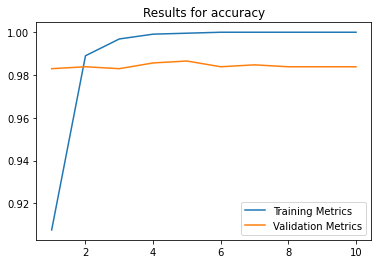

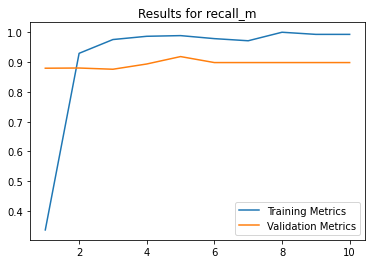

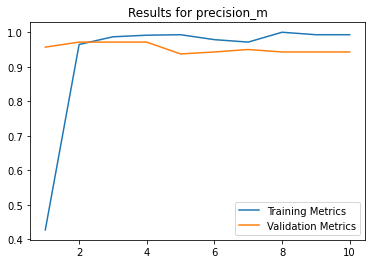

In [13]:
# Plot the evaluation metrics by each epuch for the model to see if we over or underfitting
import matplotlib.pyplot as plt

for i in ['accuracy', 'recall_m', 'precision_m']:
    acc = history.history[i]
    val_acc = history.history['val_{}'.format(i)]
    epochs = range(1, len(acc) + 1)
    
    plt.figure()
    plt.plot(epochs, acc, label='Training Metrics')
    plt.plot(epochs, val_acc, label='Validation Metrics')
    plt.title('Results for {}'.format(i))
    plt.legend()
    plt.show()